# Training a Phoneme Language Model #
In this notebook I train a language model over English sounds (also known as [phonemes](https://en.wikipedia.org/wiki/Phoneme)). Each phoneme is represented by a symbol from the [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet), or IPA. So "fish" is represented by /ˈfɪʃ/. Pronunciations in IPA are enclosed in slashes, "ˈ" indicates primary stress and "ˌ" indicates secondary stress. The rest of the symbols represent individual sounds.

By training on over a hundred thousand pronunciations I want the language model to be able to distinguish good sounding English words from less English sounding words. For example, /ˈfʌn/ ("fun") sounds good, but /ntɔˈ/ (maybe represented as "ntaw") does not.

Check out the notebook `Phoneme Exploration.ipynb` if you want to see what English words the model thinks are most standard and to see some generated words.

In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from torch.nn import functional as F
from tqdm.notebook import tqdm

from sonorous.analysis_utils import plot_pronunciation_probability
from sonorous.languagemodel import LanguageModel, ModelParams, Vocabulary
from sonorous.pronunciationdata import load_pronunciations
from sonorous.utils import split_data

plt.rcParams['figure.figsize'] = [15, 8]

## The Data ##
The data for this model comes from the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which contains over one hundred thousand pronunciations. The CMU Dict pronunciations were originally in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), but I found a version translated into the more standard [IPA](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet).

I'll use the `load_pronunciations` function to load the Pronouncing Dictionary into a Pandas DataFrame.

In [2]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")
pronunciations.sample(5)

There are 131,964 pronunciations.

Sample of 5 pronunciations:


,pronunciation,as_string,num_phonemes,num_syllables
word,,,,
witts,"(ˈ, w, ɪ, t, s)",ˈwɪts,4,1
motyka,"(ˈ, m, ɑː, t, aɪ, k, ə)",ˈmɑːtaɪkə,6,3
kneed,"(ˈ, n, iː, d)",ˈniːd,3,1
jesuit,"(ˈ, dʒ, ɛ, ʒ, uː, ɪ, t)",ˈdʒɛʒuːɪt,6,3
boehme,"(ˈ, b, oʊ, m)",ˈboʊm,3,1


Here is the pronunciation for "fish":

In [3]:
pronunciations.loc['fish']

pronunciation    (ˈ, f, ɪ, ʃ)
as_string                ˈfɪʃ
num_phonemes                3
num_syllables               1
Name: fish, dtype: object

And here are all of the pronunciations for the word "tomato":

In [4]:
pronunciations.loc['tomato']

,pronunciation,as_string,num_phonemes,num_syllables
word,,,,
tomato,"(t, ə, ˈ, m, eɪ, ˌ, t, oʊ)",təˈmeɪˌtoʊ,6,3
tomato,"(t, ə, ˈ, m, ɑː, ˌ, t, oʊ)",təˈmɑːˌtoʊ,6,3


## The Model ##
The module `languagemodel.py` contains a class `LanguageModel` that implements a simple neural language model. It's a PyTorch neural network comprised of the following layers:
1. **Embedding layer** to translate each phoneme into a dense vector. Note that in the code this is called the _encoder since it encodes input phonemes into a representation the model can work with.
2. An recurrent neural network (**RNN**) layer that processes each input phoneme sequentially and for each step generates (a) a hidden representation to pass on to the next step and (b) an output.
3. A **linear layer** that decodes the outputes (2b) into distributions over each phoneme. Note that in the code this is called the _docoder since it decodes the model's internal representations back into phonemes.

Let's go through a simple example of what happens when we pass the pronunciation /F IH1 SH/ through the model. Ultimately what I want ouf of the model is a prediction at each position of what the next phoneme should be. For example, when a well trained model is sees /F IH1/ it should know that /SH/ is likely, or at least not unlikely.

First I'll create a `Vocabulary` instance by passing in all the pronunciations. The `vocab` is used to convert phonemes into integer indices that the neural network handle. It does a few other things too, which you can see below. The `Vocabulary` class's code is in `sonorous/languagemodel.py`.

In [5]:
print(''.join(pronunciations.loc['fish'].pronunciation))

ˈfɪʃ


In [6]:
vocab = Vocabulary.from_texts(pronunciations.pronunciation.values)

print(f"There are {len(vocab)} distinct phonemes.")
print()
print("Looking up the int index for /ʃ/:", vocab['ʃ'])
print()
print("Checking whether /ʃ/ is in the vocabulary:", 'ʃ' in vocab)
print()
print("Looking up the phoneme for a specific int index:", vocab.token_from_idx(vocab['ʃ']))
print()
print("Encoding /ˈfɪʃ/:", vocab.encode_text(tuple("ˈfɪʃ")))

There are 47 distinct phonemes.

Looking up the int index for /ʃ/: 31

Checking whether /ʃ/ is in the vocabulary: True

Looking up the phoneme for a specific int index: ʃ

Encoding /ˈfɪʃ/: [ 1  5 13 22 31  2]


Now I'll define the model. Note that I'm not actually fitting the model to any data so the output will be random. The hyperparameters aren't optimal, but again that doesn't matter here since I just want to show the flow of data through the network.

The `ModelParams` class (from `sonorous/languagemodel.py` encapsulates hyperparameters and options for the model).

In [7]:
model_params = ModelParams(
    rnn_type='rnn', embedding_dimension=10, hidden_dimension=3, num_layers=1,
    max_epochs=3, early_stopping_rounds=3
)

language_model = LanguageModel(vocab, model_params, 'cpu')

Now I'll walk through what happens when we pass the word "fish" /F IH1 SH/ through the model:

In [8]:
fish_pronunciation = tuple("ˈfɪʃ")
fish_pronunciation

('ˈ', 'f', 'ɪ', 'ʃ')

The `Vocabulary.encode_text` function we saw earlier does a few things. First, it adds dummy `<START>` and `<END>` tokens to the pronunciation indicating its start and end. This allows the model to learn transition probabilities from the start of the word to the first phoneme, and from the last phoneme to the end of the word.

It then converts every phoneme to its ingeter index.

In [9]:
fish_input = vocab.encode_text(fish_pronunciation)
print(fish_input)
print()
for idx in fish_input:
    phoneme = vocab.token_from_idx(idx)
    print(f'{idx} => {phoneme}')

[ 1  5 13 22 31  2]

1 => <START>
5 => ˈ
13 => f
22 => ɪ
31 => ʃ
2 => <END>


And now we're ready to pass the input into the model's `forward` function, which takes in inputs and outputs predictions. This model's `forward` function expects a Tensor of dimension `(batch_size, NUMBER OF STEPS)`. A step here refers to a step forward in the sequence, so /<START> F IH1 SH <END>/ has 5 steps.

In [10]:
print("Input's shape:", fish_input.shape)
fish_batch_input = torch.LongTensor(fish_input).unsqueeze(0)
print("Batch input's shape:", fish_batch_input.shape)

Input's shape: (6,)
Batch input's shape: torch.Size([1, 6])


The first thing the `forward` function does is embed each phoneme using an [nn.Embedding](https://pytorch.org/docs/stable/nn.html#embedding). Each phoneme has a dedicated embedding vector of length `embedding_dimension`, so the shape of `embedded` is `(batch size, number of steps, embedding_dimension)`.

In [11]:
embedded = language_model._encoder(fish_batch_input)
print(embedded.shape)
print()
embedded

torch.Size([1, 6, 10])



tensor([[[ 0.2358,  0.0812,  0.4921,  2.0121,  1.1394, -0.0168, -0.1808,
           0.5696,  0.2853, -1.1750],
         [ 0.0177, -0.0499, -0.5503,  0.6401, -0.0039,  0.4457, -0.2539,
          -0.4336,  1.4395, -0.3192],
         [-1.0877, -0.0758, -1.1741, -0.9751, -2.1680, -1.1938,  0.6698,
           0.4226,  0.7646,  0.3113],
         [-1.1634,  0.9116, -1.1395,  0.8588, -0.3173,  1.5198, -1.0894,
          -0.5033,  0.6822, -0.7204],
         [ 0.2023, -1.0492, -0.4600, -0.6626,  1.3397,  2.5528,  0.0322,
          -0.7443,  0.2199,  1.7352],
         [ 3.0174, -0.3162, -2.0198, -0.4923,  0.2001, -1.0426, -0.0698,
          -0.2581, -0.1434, -0.5738]]], grad_fn=<EmbeddingBackward>)

I'll pass `embedded` to the [RNN layer](https://pytorch.org/docs/stable/nn.html#recurrent-layers), resulting in `rnn_output` and `hidden_state`. I won't go into detail on how RNNs work since there are many detailed posts on the web you can read, but the basic idea is a cell is applied sequentially to every token (i.e. step) in the input. At each step an output and a hidden state are produced. The hidden state can be passed on to the next step, and the output can be used to make a prediction.

The `rnn` layer below operates on the full sequence, so the results are for the entire sequence.

In [12]:
rnn_output, hidden_state = language_model._rnn(embedded)
print(rnn_output.shape)
print()
rnn_output

torch.Size([1, 6, 3])



tensor([[[-0.9798,  0.4632, -0.9725],
         [-0.7061,  0.7552, -0.7428],
         [ 0.9519,  0.7755,  0.0025],
         [-0.9005,  0.9203, -0.9741],
         [ 0.7683, -0.0068,  0.6018],
         [ 0.5360, -0.9496,  0.9670]]], grad_fn=<TransposeBackward1>)

For our application we can ignore the `hidden_state`-- the `rnn_output` is the interesting part. The first dimension is for the batch, and we only have a single input in our batch. The second dimension is for each of the input phonemes. The third dimension corresponds to `hidden_dimension`: you can think of this as the state of the RNN at each step.

As I said at the beginning of this section, I want the output of the RNN at each position to be predictions for the *next* position. So I'll apply a [linear layer](https://pytorch.org/docs/stable/nn.html#linear) to the `rnn_output`, resulting in a vector the size of the vocabularly at each position. The [softmax](https://pytorch.org/docs/stable/nn.functional.html#softmax) function normalizes the outputs into probability distributions for each prediction.

In [13]:
outputs = language_model._decoder(rnn_output)
probabilities = F.softmax(outputs, dim=-1).squeeze()
probabilities.shape

torch.Size([6, 47])

The shape of `probabilities` is (6, 47) because each of the six tokens in /ˈfɪʃ/ gets a a probability distribution over each of the 47 phonemes in the vocabulary.

The first phoneme in the input is the `<START>` token; let's see what the model thinks should come next.

In [14]:
probabilities_for_first_phoneme = probabilities[0]
most_likely_first_phoneme_idx = probabilities_for_first_phoneme.argmax().item()
most_likely_first_phoneme = vocab.token_from_idx(most_likely_first_phoneme_idx)
most_likely_first_phoneme

'tʃ'

Since the model isn't fit yet this is just a random guess. In order to get the model to make good predictions I'll need to first train a good model.

## Finding the Best Model ##
In this section I'll train a number of models on the train set and select the one that has the lowest error on the dev set. I'll split the DataFrame of pronunciations into three DataFrames, with 79% for training, 20% for dev/validation, and 1% for testing of the final model.

In [15]:
train_pronunciations, dev_pronunciations, test_pronunciations = split_data(pronunciations, dev_proportion=.2, test_proportion=.01)
len(train_pronunciations), len(dev_pronunciations), len(test_pronunciations)

(104251, 26393, 1320)

I split the corpus up into train/dev/test so that I could use the standard approach of training models with different hyperparameters and selecting the model that performs best against the dev set. The standard metric for language models is perplexity, which is a measure of how well the model predicts the pronunciations.

Note that I ran a larger parameter search before and saw that GRUs were consistently outperforming LSTMs and vanilla RNNs. Below I'm trying a large network with three layers and embedding dimension and hidden dimension of 500. This is too large of a network architecture for the relatively simple problem of word structure, but my goal here is to overfit the training set and get a sense of what kind of performance on the dev set is reasonable. I can also identify at which epoch the dev loss was lowest and later train a model using early stopping.

The GRU will train for a maximum of 50 epochs. Every five epochs I'm printing out the train and dev loss five generated pronunciations.

I'm also printing out the percentage of generated pronunciations that occurred in the train or dev sets. This isn't a rigorous way to measure whether the model is overfitting the training set, but it I've found it does seem to indicate some amount of overfitting: I've seen it get up to nearly 100% when training a large enough model for long enough.

In [16]:
%%time

large_model_parameters = ModelParams(
    rnn_type='gru', num_layers=3, embedding_dimension=500, hidden_dimension=500,
    max_epochs=25, early_stopping_rounds=25
)

large_language_model = LanguageModel(vocab, large_model_parameters, device_name='cuda')

large_train_losses, large_dev_losses = large_language_model.fit(
    train_pronunciations.pronunciation.values.tolist(),
    dev_pronunciations.pronunciation.values.tolist(),
    print_every=5,
)

large_results = pd.DataFrame({
    'epoch': range(1, len(large_train_losses) + 1),
    'train_loss': large_train_losses,
    'dev_loss': large_dev_losses,
}).set_index('epoch')

Epoch 5: train loss: 0.4883	dev loss: 0.7207                                                                                               
	Generated: in train: 17%, assess: 4%, novel: 79%
	 ˈ æ m b ɝ z
	 ˌ m ɛ n s ə b ˈ j uː z
	 ˈ k l ɔ r i
	 ˈ k oʊ z oʊ s
	 ˈ ɛ n d ɪ ŋ
Epoch 10: train loss: 0.4492	dev loss: 0.6908                                                                                               
	Generated: in train: 20%, assess: 1%, novel: 79%
	 ˈ g r æ n s
	 ˈ k oʊ l z
	 ˈ g ʌ d ˌ f i
	 d ɪ ˈ s ɝː p t ɪ v l i
	 ˈ r uː b ə
Epoch 15: train loss: 0.4124	dev loss: 0.6800                                                                                               
	Generated: in train: 28%, assess: 1%, novel: 70%
	 ˈ m ʌ n iː ˌ s iː m
	 m ɑː n ˈ k ɑː l ə
	 ˈ b l oʊ k ɔ f
	 ˈ h j uː n ɝ
	 ˈ b ɛ r i
Epoch 20: train loss: 0.3829	dev loss: 0.6867                                                                                               
	Generated: in train: 42%, assess: 1%

In [17]:
large_results = pd.DataFrame({
    'epoch': range(1, len(large_train_losses) + 1),
    'train_loss': large_train_losses,
    'dev_loss': large_dev_losses,
}).set_index('epoch')

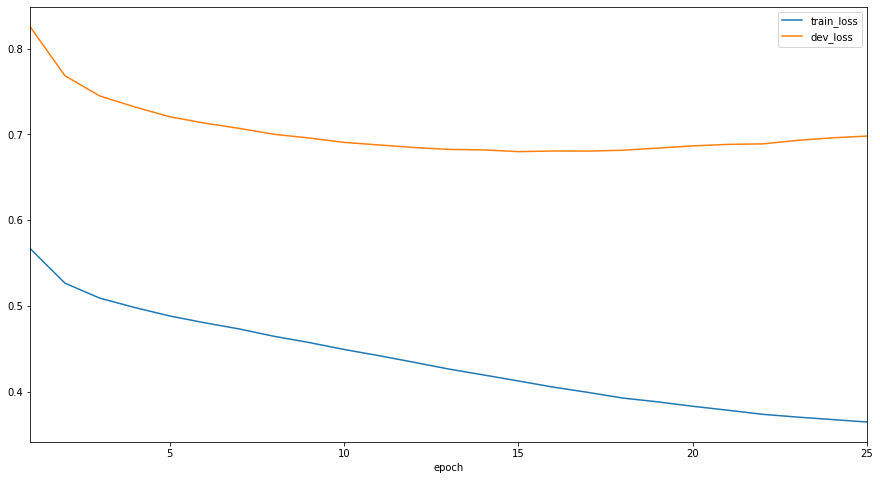

In [18]:
_ = large_results.plot()

In [19]:
large_results.sort_values('dev_loss').head()

,train_loss,dev_loss
epoch,,
15,0.412386,0.679980
17,0.399027,0.680581
16,0.405207,0.680687
18,0.392395,0.681612
14,0.419424,0.681979


In [20]:
large_results.iloc[-1]

train_loss    0.364454
dev_loss      0.698131
Name: 25, dtype: float64

The dev loss is important because it tells me how well the model is doing at predicting pronunciations it's never seen before. If the model just memorizes the exact sequence of phonemes in the training set then performance on the dev set will suffer since it won't generalize.

By epoch 25 the model has overfit the training set, with dev loss climbing back up to .698 from its low of .679. Also, at this point 53% of generated words were present in the training set, again indicating oerfitting.

Another illustration of how much the model has overfit is the chart below, which shows the model's assigned probability for each phoneme in /ˌænəsˌθiːziːˈɑːlədʒɪst/.

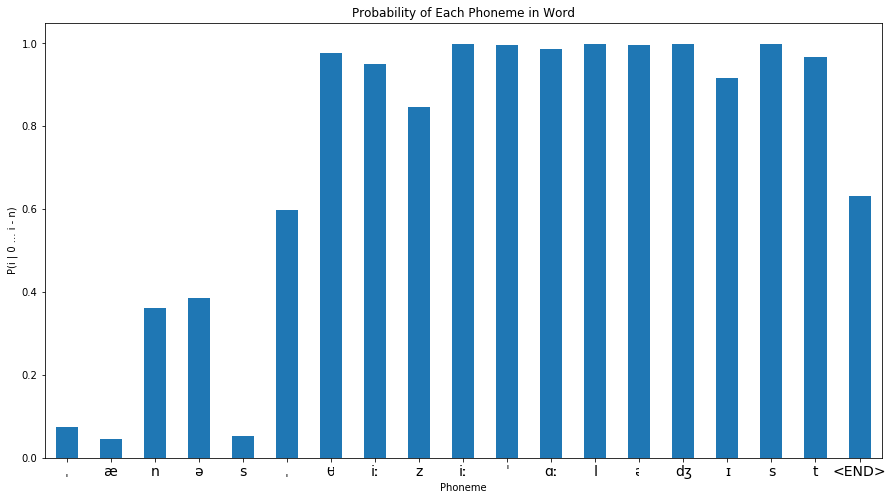

In [21]:
plot_pronunciation_probability(
    large_language_model,
    ('ˌ', 'æ', 'n', 'ə', 's', 'ˌ', 'θ', 'iː', 'z', 'iː', 'ˈ', 'ɑː', 'l', 'ə', 'dʒ', 'ɪ', 's', 't')
)

In [22]:
(train_pronunciations.as_string=='ˌænəsˌθiːziːˈɑːlədʒɪst').sum()

2

After seeing /ˌænəsˌ/ the model is almost entirely certain of each of the next phonemes that follows. This pronunciation appears twice in the training set, so the model appears to have memorized it.

If I view the full CMU Dict as encompassing *all* of English then it's arguably ok to fit it very well since there's no need to generalize to new words. But I'm hoping to capture English pronunciaiton rules at a more general level than exact words, so that the model will generate words that aren't exactly like the training corpus.

Dev loss was at its minimum at epoch 16 so I'll train another model with the same parameters for 16 epochs. Note that I could also try smaller model architectures or regularizing while still training until convergence, but this is faster since I don't need to train a large number of models.

In [23]:
%%time

early_stopped_model_params = ModelParams(
    rnn_type='gru', num_layers=3, embedding_dimension=500, hidden_dimension=500,
    max_epochs=16, early_stopping_rounds=16
)

early_stopped_language_model = LanguageModel(vocab, early_stopped_model_params, device_name='cuda')

_ = early_stopped_language_model.fit(
    train_pronunciations.pronunciation.values.tolist(),
    dev_pronunciations.pronunciation.values.tolist(),
    print_every=5,
)

Epoch 5: train loss: 0.4895	dev loss: 0.7222                                                                                               
	Generated: in train: 11%, assess: 0%, novel: 89%
	 ˈ v æ ŋ g ɝ d
	 ˈ t uː t
	 ˈ l ɛ b ɪ s t
	 tʃ iː θ ɑː ˈ r ɑː s iː oʊ
	 v ɪ s ɛ ˈ n ɑː θ ə
Epoch 10: train loss: 0.4498	dev loss: 0.6914                                                                                               
	Generated: in train: 18%, assess: 3%, novel: 79%
	 ˈ p ɛ l ˌ b r ʊ k
	 ˈ k ɑː ŋ k ə n
	 ˈ tʃ ɪ p
	 ˈ w iː z l i
	 ˈ w aɪ l ɝ
Epoch 15: train loss: 0.4117	dev loss: 0.6804                                                                                               
	Generated: in train: 30%, assess: 0%, novel: 70%
	 ˈ f l ɔ r ˌ m ɛ n t
	 ˈ s m ɑː f i
	 ˈ æ l f r ə n
	 ˈ ɛ r d
	 ˈ k ɑː l m ə n
Epoch 16: train loss: 0.4056	dev loss: 0.6816                                                                                               
	Generated: in train: 21%, assess: 3%, 

Dev loss here does in fact match dev loss in the model above at epoch 16. I'll now look again at /ˌænəsˌθiːziːˈɑːlədʒɪst/:

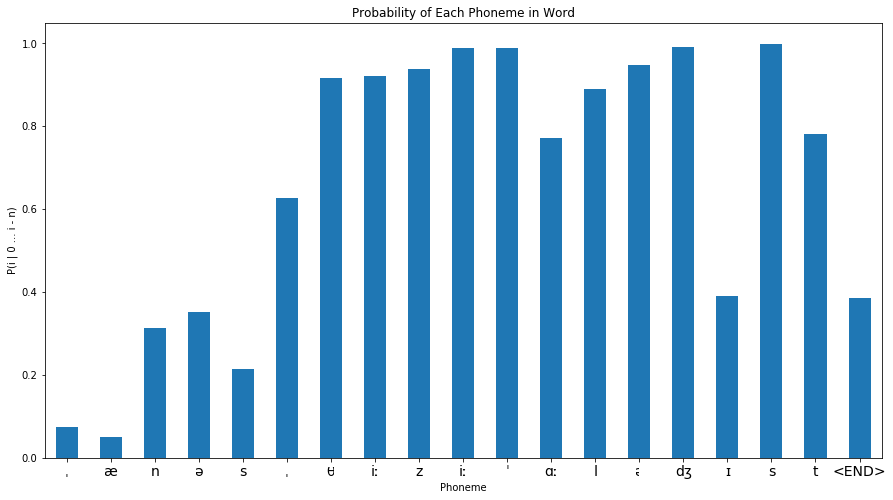

In [24]:
plot_pronunciation_probability(
    early_stopped_language_model,
    ('ˌ', 'æ', 'n', 'ə', 's', 'ˌ', 'θ', 'iː', 'z', 'iː', 'ˈ', 'ɑː', 'l', 'ə', 'dʒ', 'ɪ', 's', 't')
)

Even though this model didn't technically overfit the training set, the model is still way more confident in its predictions than I would have hoped.

So ultimately I'll abandon my dev set perplexity as my metric. Language models are often evaluated on downstream tasks, but unfortunately I don't have a clear metric for my downstream task of generating "good" English pronunciations. I instead generated about 10 models and manually inspected them, looking for models that have the following characteristics:
* Doesn't horribly overfit long words in the training set
* Both low and high perplexity pronunciations from the training set make sense
* The generated pronunciations feel pronouncable to me

The model I ended up liking most is a GRU with an embedding dimension of 20, hidden dimension of 20, and a single layer. I train it until train loss stops dropping, so there's no early stopping here.

In [25]:
%%time

smallish_model_parameters = ModelParams(
    rnn_type='gru', num_layers=1, embedding_dimension=20, hidden_dimension=20,
    max_epochs=1000, early_stopping_rounds=3
)

smallish_language_model = LanguageModel(vocab, smallish_model_parameters, device_name='cuda')

_ = smallish_language_model.fit(
    train_pronunciations.pronunciation.values.tolist(),
    dev_pronunciations.pronunciation.values.tolist(),
    print_every=50,
)

Epoch 50: train loss: 0.5415	dev loss: 0.7894                                                                                               
	Generated: in train: 3%, assess: 0%, novel: 97%
	 ˈ s k ɪ ŋ b ə l
	 ˈ m aɪ t ˌ r ɑː s t ə ˌ k uː t
	 ɑː ˈ r ɛ n d iː ɝ
	 ˈ uː d ə ˌ g eɪ b ɝ
	 ˈ r ɔ r n ə
Epoch 100: train loss: 0.5311	dev loss: 0.7751                                                                                               
	Generated: in train: 13%, assess: 1%, novel: 86%
	 ˈ ɛ n ˌ r ə s t
	 ˈ dʒ ʌ k f l oʊ
	 p ɪ ˈ k ɑː tʃ
	 ˈ l aɪ t ə n
	 ˈ l æ k ə l iː z
Epoch 150: train loss: 0.5279	dev loss: 0.7706                                                                                               
	Generated: in train: 10%, assess: 3%, novel: 87%
	 ˈ s t ɛ l oʊ s
	 ˈ t æ θ s t
	 ˈ æ m p ə ˌ s t r iː z
	 ˈ s ɪ l ə s ə
	 b ɪ ˈ z ɛ r
Epoch 200: train loss: 0.5261	dev loss: 0.7682                                                                                               
	Gene

Early stopping because of no decrease in 3 epochs.


The dev loss of this model is considerably higher than the more optimal model I trained above. But in practice I found that its predictions made sense to me. So this means that a loss of about .76 gets us pretty close to representing the basic structure of allowable English pronunciations, whereas the much lower loss occurs when a model has learned the probabilities of long sequences of phonemes. 

I'll see what this new, *smallish*, model predicts for /ˌænəsˌθiːziːˈɑːlədʒɪst/:

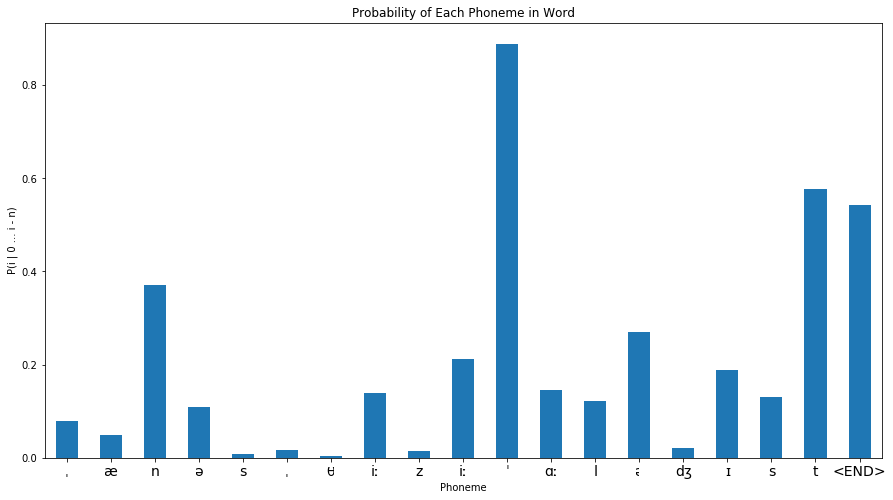

In [26]:
plot_pronunciation_probability(
    smallish_language_model,
    ('ˌ', 'æ', 'n', 'ə', 's', 'ˌ', 'θ', 'iː', 'z', 'iː', 'ˈ', 'ɑː', 'l', 'ə', 'dʒ', 'ɪ', 's', 't')
)

While many of the probabilities the model assigns are still suspiciously high, this looks better than the previous models.

## Training the Final Model ##
Now that I've found the best parameters for the model according to the dev set I'll train a final model using all of the data. This should increase model performance overall since more data is better, but is also necessary since I'll be using the model to predict probabilities of all English words. If some of those words weren't in the training set they would artificially get lower probabilities. (Another approach here could be to train a model on e.g. 4/5 folds of the data and make predictions about the remaining 1/5, doing that 5 times to get unbiased predictions for all data, but this would have taken much longer to run.)

In [27]:
%%time


final_language_model = LanguageModel(vocab, smallish_model_parameters, device_name='cuda')

_ = final_language_model.fit(
    pronunciations.pronunciation.values.tolist(),
    print_every=50,
)


Epoch 50: train loss: 0.5409loss: 0.5461                                                                                                    
	Generated: in train: 16%, assess: 0%, novel: 84%
	 ˈ m ɔɪ m ə n t
	 r uː ˈ n iː dʒ ɪ v
	 s ə ˈ t r t eɪ n z
	 ə ʃ ˈ tʃ oʊ p ɝ k
	 ˈ h ɔɪ n ɝ
Epoch 100: train loss: 0.5325loss: 0.5357                                                                                                    
	Generated: in train: 12%, assess: 0%, novel: 88%
	 k ə t ˈ ɝː d ə k
	 ə n ˈ t r iː s l ɝ
	 ˈ b ʊ k
	 z ə ˈ k ɔ n t iː z
	 ˈ h ɝː t ə s ɪ ŋ
Epoch 150: train loss: 0.5299loss: 0.5286                                                                                                    
	Generated: in train: 5%, assess: 0%, novel: 95%
	 v ɑː ˈ k ɝː g ə n t
	 ˌ iː v ɛ r t ə ˈ l æ m p i
	 ˈ t æ t r ə
	 ˌ t æ n ə n ˈ t r ɔ f k ə
	 ˈ w eɪ m ɝ z
Epoch 200: train loss: 0.5282loss: 0.5163                                                                                               

Early stopping because of no decrease in 3 epochs.


And finally, I'll save the model so I can use it in the next notebook, `Phoneme Exploration.ipynb`.

In [28]:
with open('models/gru_20_20_1.pt', 'wb') as fh:
    final_language_model.save(fh)